In [16]:
# pip install transformers timm flash_attn einops

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
from transformers import AutoProcessor, AutoModelForCausalLM
import matplotlib.pyplot as plt
from PIL import Image
import requests
import copy
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    # Convert the image to RGB format explicitly
    image_rgb = image.convert("RGB")
    inputs = processor(text=prompt, images=image_rgb, return_tensors="pt") # Pass the RGB image to the processor
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image_rgb.width, image_rgb.height) # Use dimensions of the RGB image
    )

    return parsed_answer

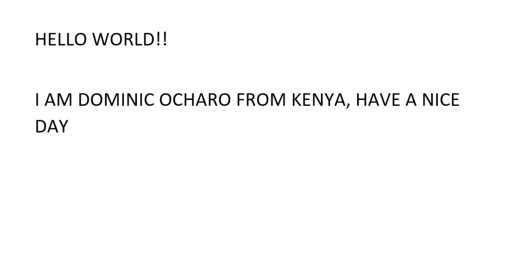

In [14]:
image_path = '/content/drive/MyDrive/autolabel/OCR_TEST.jpg'

image = Image.open(image_path)
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.show()

In [15]:
image = Image.open(image_path)
task_prompt = '<OCR>'
print(run_example(task_prompt)["<OCR>"].strip())

HELLO WORLD!!I AM DOMINIC OCHARO FROM KENYA, HAVE A NICEDAY


In [18]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 3.2 MB/s eta 0:00:00


In [19]:
import supervision as sv
from typing import Dict

def run_example(task_prompt: str, text_input: str="", image=image) -> Dict:
    prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        pixel_values=inputs["pixel_values"].cuda(),
        max_new_tokens=1024,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    print(generated_text)

    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))

    return parsed_answer

</s><s><s>HELLO WORLD!!<loc_49><loc_86><loc_318><loc_86><loc_318><loc_148><loc_49><loc_148>I AM DOMINIC OCHARO FROM KENYA, HAVE A NICE<loc_48><loc_322><loc_907><loc_322><loc_907><loc_387><loc_48><loc_387>DAY<loc_49><loc_429><loc_117><loc_429><loc_117><loc_486><loc_49><loc_486></s>
{'<OCR_WITH_REGION>': {'quad_boxes': [[62.66699981689453, 56.484500885009766, 403.22100830078125, 56.484500885009766, 403.22100830078125, 96.97049713134766, 62.66699981689453, 96.97049713134766], [61.4010009765625, 210.59249877929688, 1148.89501953125, 210.59249877929688, 1148.89501953125, 253.03750610351562, 61.4010009765625, 253.03750610351562], [62.66699981689453, 280.4635009765625, 148.7550048828125, 280.4635009765625, 148.7550048828125, 317.68450927734375, 62.66699981689453, 317.68450927734375]], 'labels': ['</s>HELLO WORLD!!', 'I AM DOMINIC OCHARO FROM KENYA, HAVE A NICE', 'DAY']}}


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


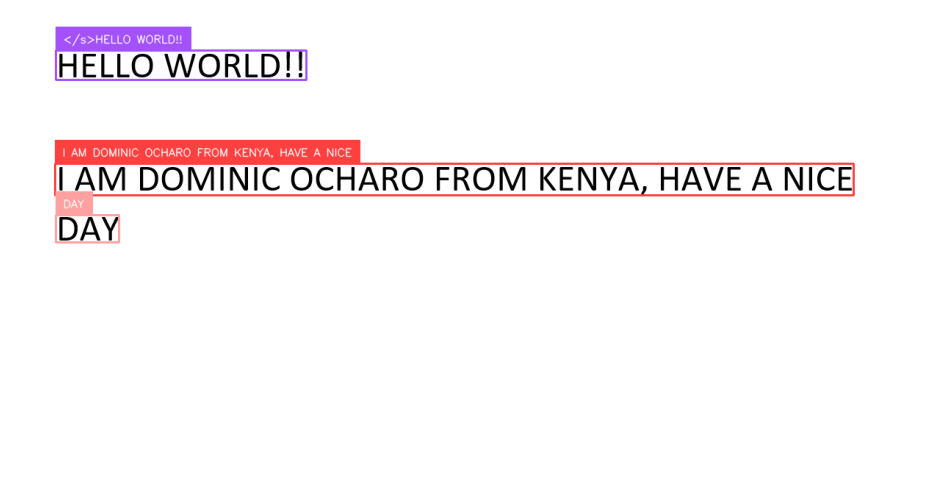

In [20]:
image = Image.open(image_path).convert("RGB")
task_prompt = "<OCR_WITH_REGION>"
answer = run_example(task_prompt=task_prompt, image=image)

print(answer)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, answer, resolution_wh=image.size)
annotated = bounding_box_annotator.annotate(image, detections=detections)
annotated = label_annotator.annotate(annotated, detections=detections)
sv.plot_image(annotated)